# Audio Classification

This is a short tutorial to show how to load and classify sound files.

In [28]:
import numpy
import IPython


In [21]:
from audio_loader import load_all
from playsound import play_and_save_sound

In [39]:
%matplotlib notebook
%matplotlib inline

In [33]:
IPython.display.Audio(filename="input/categorized/frog/2-32515-A-4.wav")

soundpath updated to input/categorized/frog/2-32515-A-4.wav
x_train shape: (40, 163840, 1)
40 train samples
Saving arrays to file
count    163840.000000
mean         -6.412695
std        6665.109297
min      -32768.000000
25%        -907.000000
50%          -9.000000
75%         854.250000
max       32767.000000
dtype: float64
h
playing and saving sound from category original folder jupytertesting


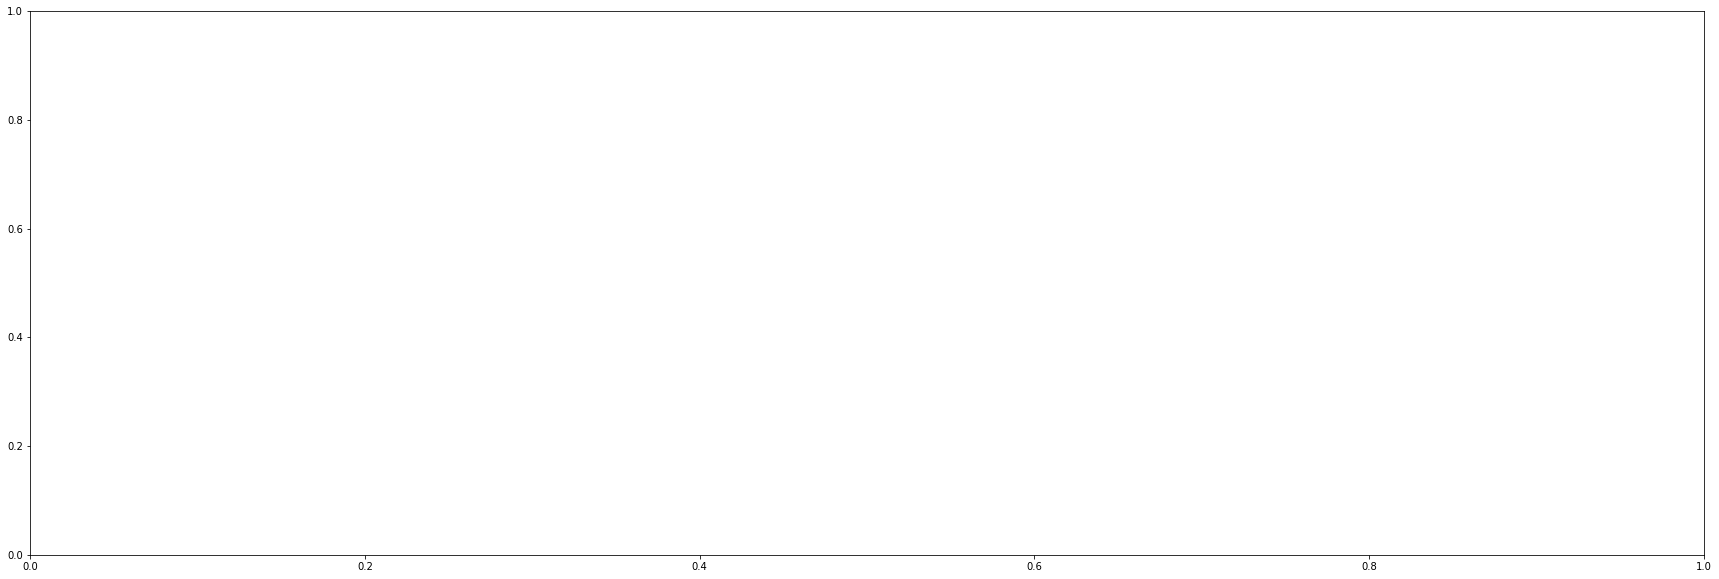

In [40]:
sound = load_all("categorized", "frog",forceLoad=True,framerate=32768)

play_and_save_sound(sound, "jupytertesting", "original", upscale=False)

NameError: name 'plt' is not defined

In [38]:
IPython.display.Audio(filename="output/jupytertesting/original#0.wav")